# Predicting bank products campaign outcome

## Table of Contents:

1. [Data Visualization](#data-visualization)
1. [Data Proprocessing](#data-preprocessing)
    1. [Check for missing values](#missing-values)
    1. [Check outliers for numeric features and remove if necessary](#outliers)
    1. [Feature encoding](#feature-encoding)
    1. [Split the data](#split)
    1. [Feature scaling](#feature-scaling)
1. [Feature Engineering](#feature-engineering)
    1. [Correlation matrix](#matrix)
    1. [Apply SMOTE for minority over sampling](#smote)
    1. [Apply PCA dimensionality reduction](#pca)
1. [Developing Models](#developing-models)
    1. [Create a Logistic Regression model](#lr)
    1. [Create a Multilayer Perceptron model](#mlp)
    1. [Create a Random Forest model](#rf)
    1. [Compare results and plot them](#compare-results)
1. [Conclusion](#conclusion)
1. [Deployment](#deployment)

## 1. Data Visualization <a class="anchor" id="data-visualization"></a>
### Load data into memory

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
bankInputFile = "bank-additional-full.csv"
bank_data = pd.read_csv(bankInputFile, sep=';')
bank_data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### View some details of the data
We check the rows and columns numbers of the data, and then for each column we check its type, i.e. either numeric or categorical. 

In [3]:
# show the number of rows and columns
bank_data.shape

(41188, 21)

In [4]:
# show the feature types
bank_data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
# these are the numeric columns
num_cols = bank_data._get_numeric_data().columns.tolist()
# these are the categorical columns
cat_cols = list(set(bank_data.columns) - set(num_cols))
print("Numeric columns are: " + str(num_cols))
print("Categorical columns are: " + str(cat_cols))

Numeric columns are: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns are: ['y', 'default', 'month', 'housing', 'day_of_week', 'marital', 'education', 'loan', 'poutcome', 'contact', 'job']


Note the 'y' feature is whether the customer has decided to purchase the bank products. Let's check if it is a balanced data set.

In [6]:
bank_data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

It is imbalanced as the label of no' is almost 9 times of the label 'yes'. We will use SMOTE later to oversamle the minority class.

### plot age against campaign outcome
there are more people in the age group of 0-40 who have subscribed to the term deposit

Text(0.5, 1.0, 'Age groups')

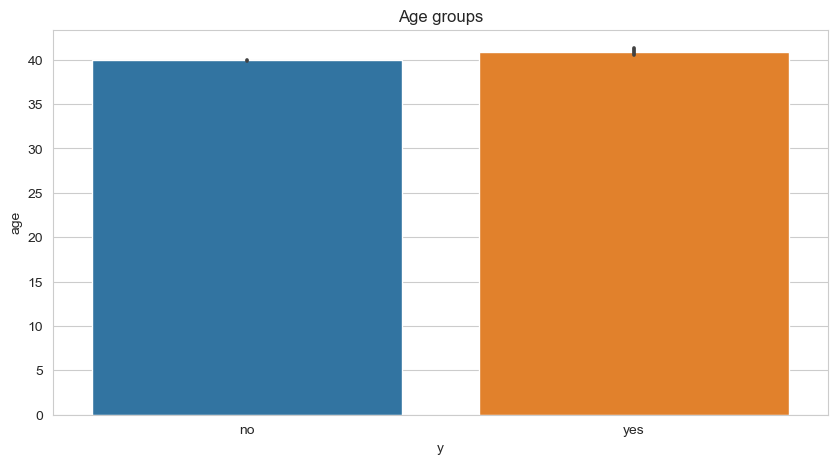

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize = (10, 5))
sns.barplot(x=bank_data['y'], y=bank_data['age'])
plt.title("Age groups")

### plot job types
Show the distribution of people's professions. It seems admin, blue-colar and technicians are the top three who are more likely to join the campaign.

Text(0.5, 1.0, 'Job Types')

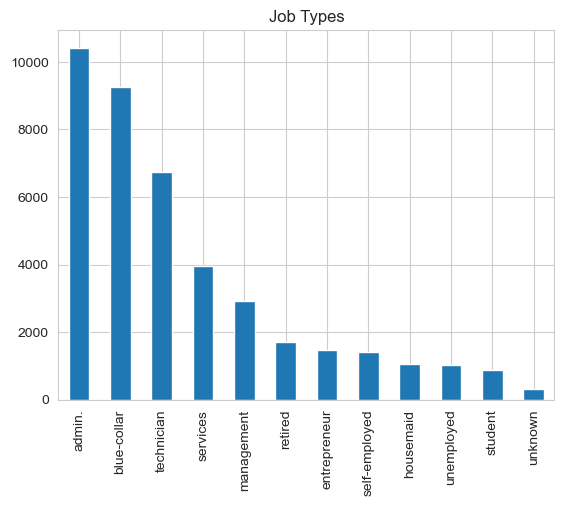

In [8]:
job_count = bank_data['job'].value_counts()
job_count.plot(kind = "bar")
plt.title("Job Types")

### plot education
People with a university degree has the most number in participating in the campaign.
In general, education level is highly correlated with participation, following a trend of the higher one's education level is, the more likely they will participate in the campaign.

Text(0.5, 1.0, 'Education Levels')

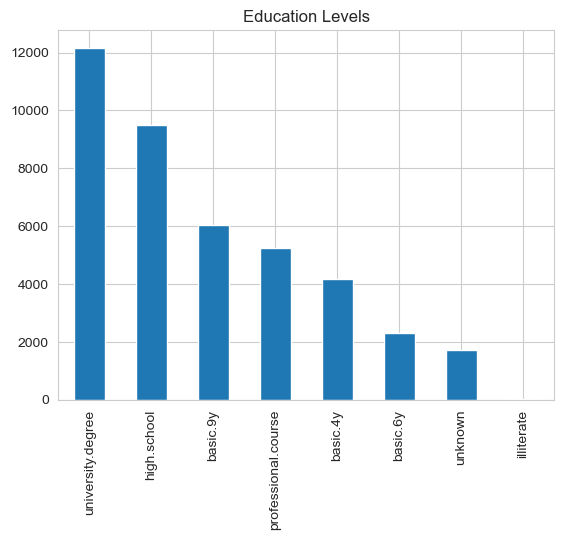

In [9]:
job_count = bank_data['education'].value_counts()
job_count.plot(kind = "bar")
plt.title("Education Levels")

### Barplots separated by the above categorical data

In [10]:
def barplot(hue,title):
    fig, axes =plt.subplots(1,2, figsize=(12,4))
    fig.suptitle(title)
    sns.barplot(x='age',y='y',hue=hue,data=bank_data,ax=axes[0])
    sns.barplot(x='campaign',y='y',hue=hue,data=bank_data,ax=axes[1])
    fig.tight_layout()

On the job types side, some professions are more likely to subscribe to the term deposit when they get older, such as housemaids and retired population. Some other professions are not likely to change their subscribing decisions based on age, such as blue-collars. And some professions like students and self-employed population are more likely to subscribe when they are younger.
With more campaign attempted, some professions are more likely to subscribe, such as enterpreneurs.

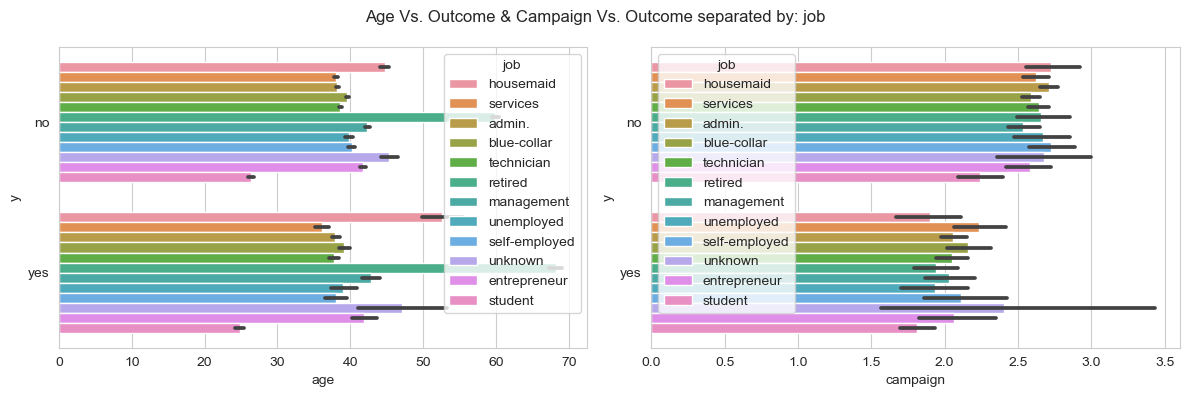

In [11]:
barplot('job','Age Vs. Outcome & Campaign Vs. Outcome separated by: job')

Some education level categories are likely to influence subscribing outcome. For example, for age group that's over 50, illiterate and basic 4y groups tend to purchase the product than the age group that's below 50 with the same education. When we look at the right plot, it seems most success comes from around 2 campaigns. Beyond this point, customers are more likely to reject a subscription.

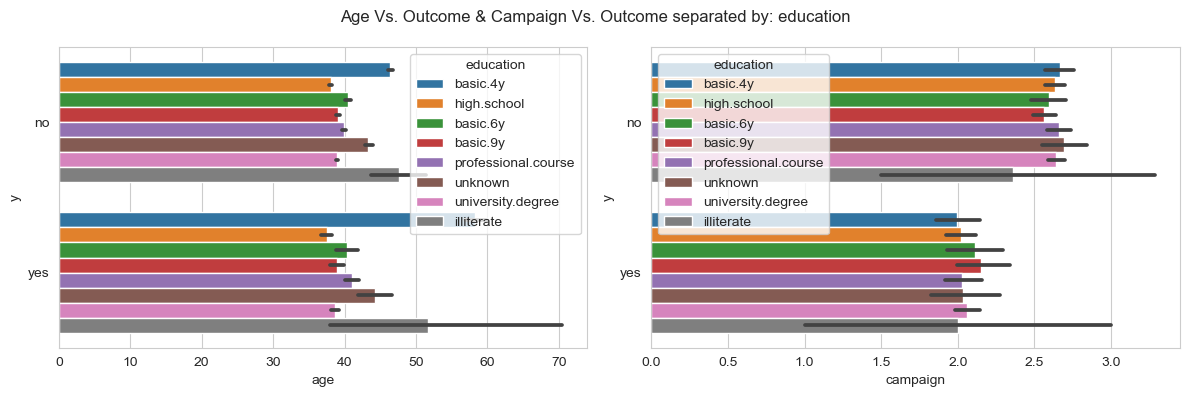

In [12]:
barplot('education','Age Vs. Outcome & Campaign Vs. Outcome separated by: education')

## 2. Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

### checking for missing values <a class="anchor" id="missing-values"></a>
First check the null values for each column

In [13]:
print(bank_data.isnull().sum())
# there is no null values

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


We also notice there're 'unknown' values in 6 columns. It is hard to tell if they are part of features so for now we leave them be.

In [14]:
unknown = ["unknown"]
unknown_data = pd.read_csv('bank-additional-full.csv',sep=';', na_values = unknown)
print(unknown_data.isnull().sum())

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


### Check outliers for numeric features and remove outliers if necessary <a class="anchor" id="outliers"></a>

First we look at the age column:
The result shows there are many lying above 70% quantile but the data points are relatively dense. Hence I am not going to remove them as they might carry useful information

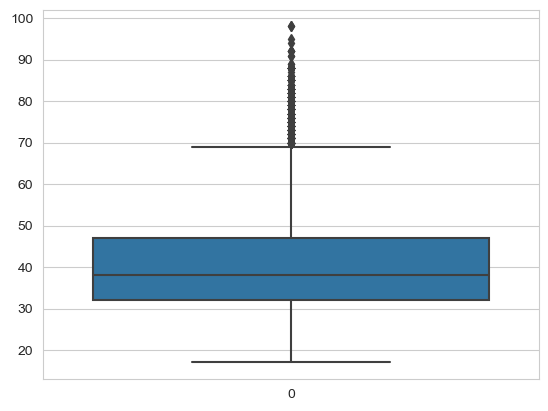

In [15]:
max_val = bank_data.age.quantile(0.75)
min_val = bank_data.age.quantile(0.25)

sns.boxplot(bank_data['age'])
plt.show()

Next, we check the duration column.

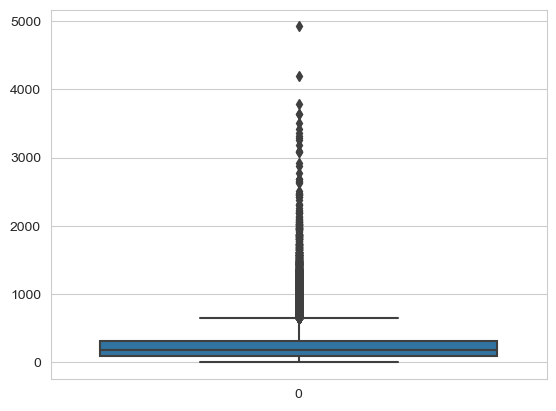

In [16]:
max_val = bank_data.duration.quantile(0.75)
min_val = bank_data.duration.quantile(0.25)

sns.boxplot(bank_data['duration'])
plt.show()

Data gets significantly sparse after 3800, so I remove the values beyond this point. Now the outliers look more dense.

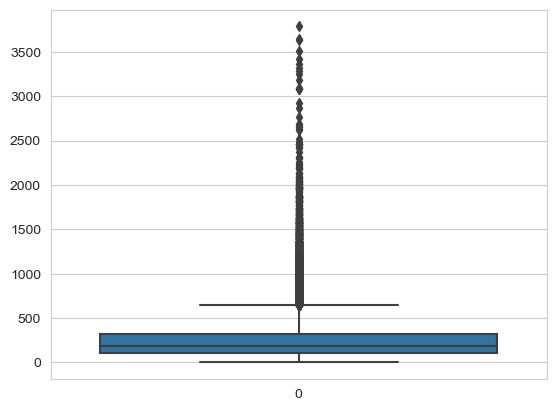

In [17]:
bank_data = bank_data[(bank_data['duration']<3800)]
sns.boxplot(bank_data['duration'])
plt.show()

Next, we look at the campaign column. Following the same idea above, I remove data points beyond 45.

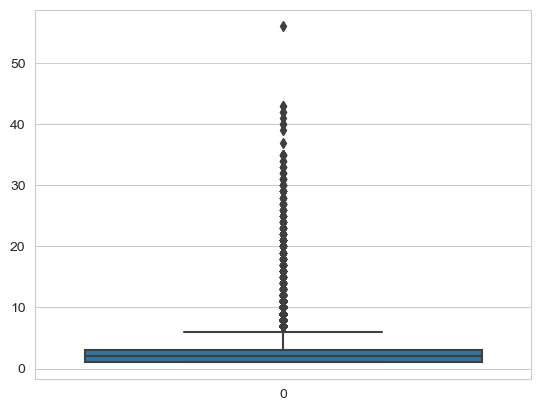

In [18]:
max_val = bank_data.campaign.quantile(0.75)
min_val = bank_data.campaign.quantile(0.25)

sns.boxplot(bank_data['campaign'])
plt.show()

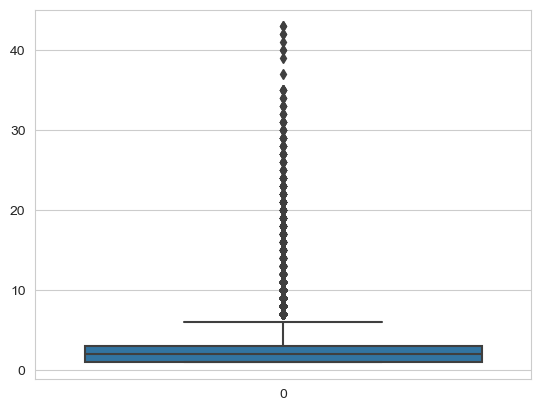

In [19]:
bank_data = bank_data[(bank_data['campaign']<45)]
sns.boxplot(bank_data['campaign'])
plt.show()

### Feature encoding <a class="anchor" id="feature-encoding"></a>
Categorical data needs to transfrom into numeric. For binary categorical data such as 'default', 'housing', 'loan', 'y', we use the lambda function to convert 'yes' to 1 and 'no' to 0. For non-binary columns, we use one-hot encoding.

In [20]:
binary_valued_features = ['default','housing', 'loan']
bin_dict = {'yes':1, 'no':0}

#Replace binary values in data using the provided dictionary
for item in binary_valued_features:
    bank_data[item] = bank_data[item].apply(lambda row: 1 if row == 'yes' else 0)
bank_data['target'] = bank_data['y'].apply(lambda row: 1 if row == 'yes' else 0)
bank_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,target
0,56,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,0,1,0,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1
41184,46,blue-collar,married,professional.course,0,0,0,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41185,56,retired,married,university.degree,0,1,0,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41186,44,technician,married,professional.course,0,0,0,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1


In [21]:
# Using OneHotEncoding pandas.get_dummies
categorial_features = ['job', 'marital', 'education', 'contact', 'poutcome']
for item in categorial_features:
    # assigning the encoded data into a new DataFrame object
    df = pd.get_dummies(bank_data[item], prefix=item)
    bank_data = bank_data.drop(item, axis=1)
    for categorial_feature in df.columns:
        #Set the new column in data to have corresponding df values
        bank_data[categorial_feature] = df[categorial_feature]

bank_data

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,0,0,0,may,mon,261,1,999,0,...,0,0,0,0,0,0,1,0,1,0
1,57,0,0,0,may,mon,149,1,999,0,...,1,0,0,0,0,0,1,0,1,0
2,37,0,1,0,may,mon,226,1,999,0,...,1,0,0,0,0,0,1,0,1,0
3,40,0,0,0,may,mon,151,1,999,0,...,0,0,0,0,0,0,1,0,1,0
4,56,0,0,1,may,mon,307,1,999,0,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0,1,0,nov,fri,334,1,999,0,...,0,0,1,0,0,1,0,0,1,0
41184,46,0,0,0,nov,fri,383,1,999,0,...,0,0,1,0,0,1,0,0,1,0
41185,56,0,1,0,nov,fri,189,2,999,0,...,0,0,0,1,0,1,0,0,1,0
41186,44,0,0,0,nov,fri,442,1,999,0,...,0,0,1,0,0,1,0,0,1,0


We also convert month and day_of_week into numeric values.

In [22]:
months = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec': 12}
bank_data['month'] = bank_data['month'].map(months)
day_of_week = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
bank_data['day_of_week'] = bank_data['day_of_week'].map(day_of_week)
bank_data

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,0,0,0,5,1,261,1,999,0,...,0,0,0,0,0,0,1,0,1,0
1,57,0,0,0,5,1,149,1,999,0,...,1,0,0,0,0,0,1,0,1,0
2,37,0,1,0,5,1,226,1,999,0,...,1,0,0,0,0,0,1,0,1,0
3,40,0,0,0,5,1,151,1,999,0,...,0,0,0,0,0,0,1,0,1,0
4,56,0,0,1,5,1,307,1,999,0,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0,1,0,11,5,334,1,999,0,...,0,0,1,0,0,1,0,0,1,0
41184,46,0,0,0,11,5,383,1,999,0,...,0,0,1,0,0,1,0,0,1,0
41185,56,0,1,0,11,5,189,2,999,0,...,0,0,0,1,0,1,0,0,1,0
41186,44,0,0,0,11,5,442,1,999,0,...,0,0,1,0,0,1,0,0,1,0


'pdays' indicates how many days have passed since the customer was contacted by the bank. We convert it into a binary valule, with -1 turned into 0, and other values turned into 1. 

In [23]:
bank_data['was_contacted'] = bank_data['pdays'].apply(lambda row: 0 if row == -1 else 1)

We can see all categorical data has been transformed into numeric data.

In [24]:
bank_data.drop(['y'], axis=1, inplace=True)
bank_data.dtypes

age                                int64
default                            int64
housing                            int64
loan                               int64
month                              int64
day_of_week                        int64
duration                           int64
campaign                           int64
pdays                              int64
previous                           int64
emp.var.rate                     float64
cons.price.idx                   float64
cons.conf.idx                    float64
euribor3m                        float64
nr.employed                      float64
target                             int64
job_admin.                         uint8
job_blue-collar                    uint8
job_entrepreneur                   uint8
job_housemaid                      uint8
job_management                     uint8
job_retired                        uint8
job_self-employed                  uint8
job_services                       uint8
job_student     

### Split the data <a class="anchor" id="split"></a>

In [25]:
X = bank_data.drop('target', axis=1)
y = bank_data['target']
print(X.shape, y.shape)
# spliting training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=35)

(41185, 45) (41185,)


### Feature scaling <a class="anchor" id="feature-scaling"></a>
It's better to standardize the numeric features by applying feature scaling. Here I use the StandardScaler from sklearn, which removes the mean and scale to unit variance.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  
scaler.fit(X)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## 3. Feature Engineering <a class="anchor" id="feature-engineering"></a>

Here we will look at the confusion matrix to decide if there is any feature that needs to be removed. Then we apply SMOTE to address the imbalanced data set. Lastly, we use PCA for dimentionality reduction.
To begin with, the below plot shows highly correlated features with the value. Usually we need to remove such features as they are linearly dependent on other features do not offer much information in making predictions. 

### Correlation matrix <a class="anchor" id="matrix"></a>

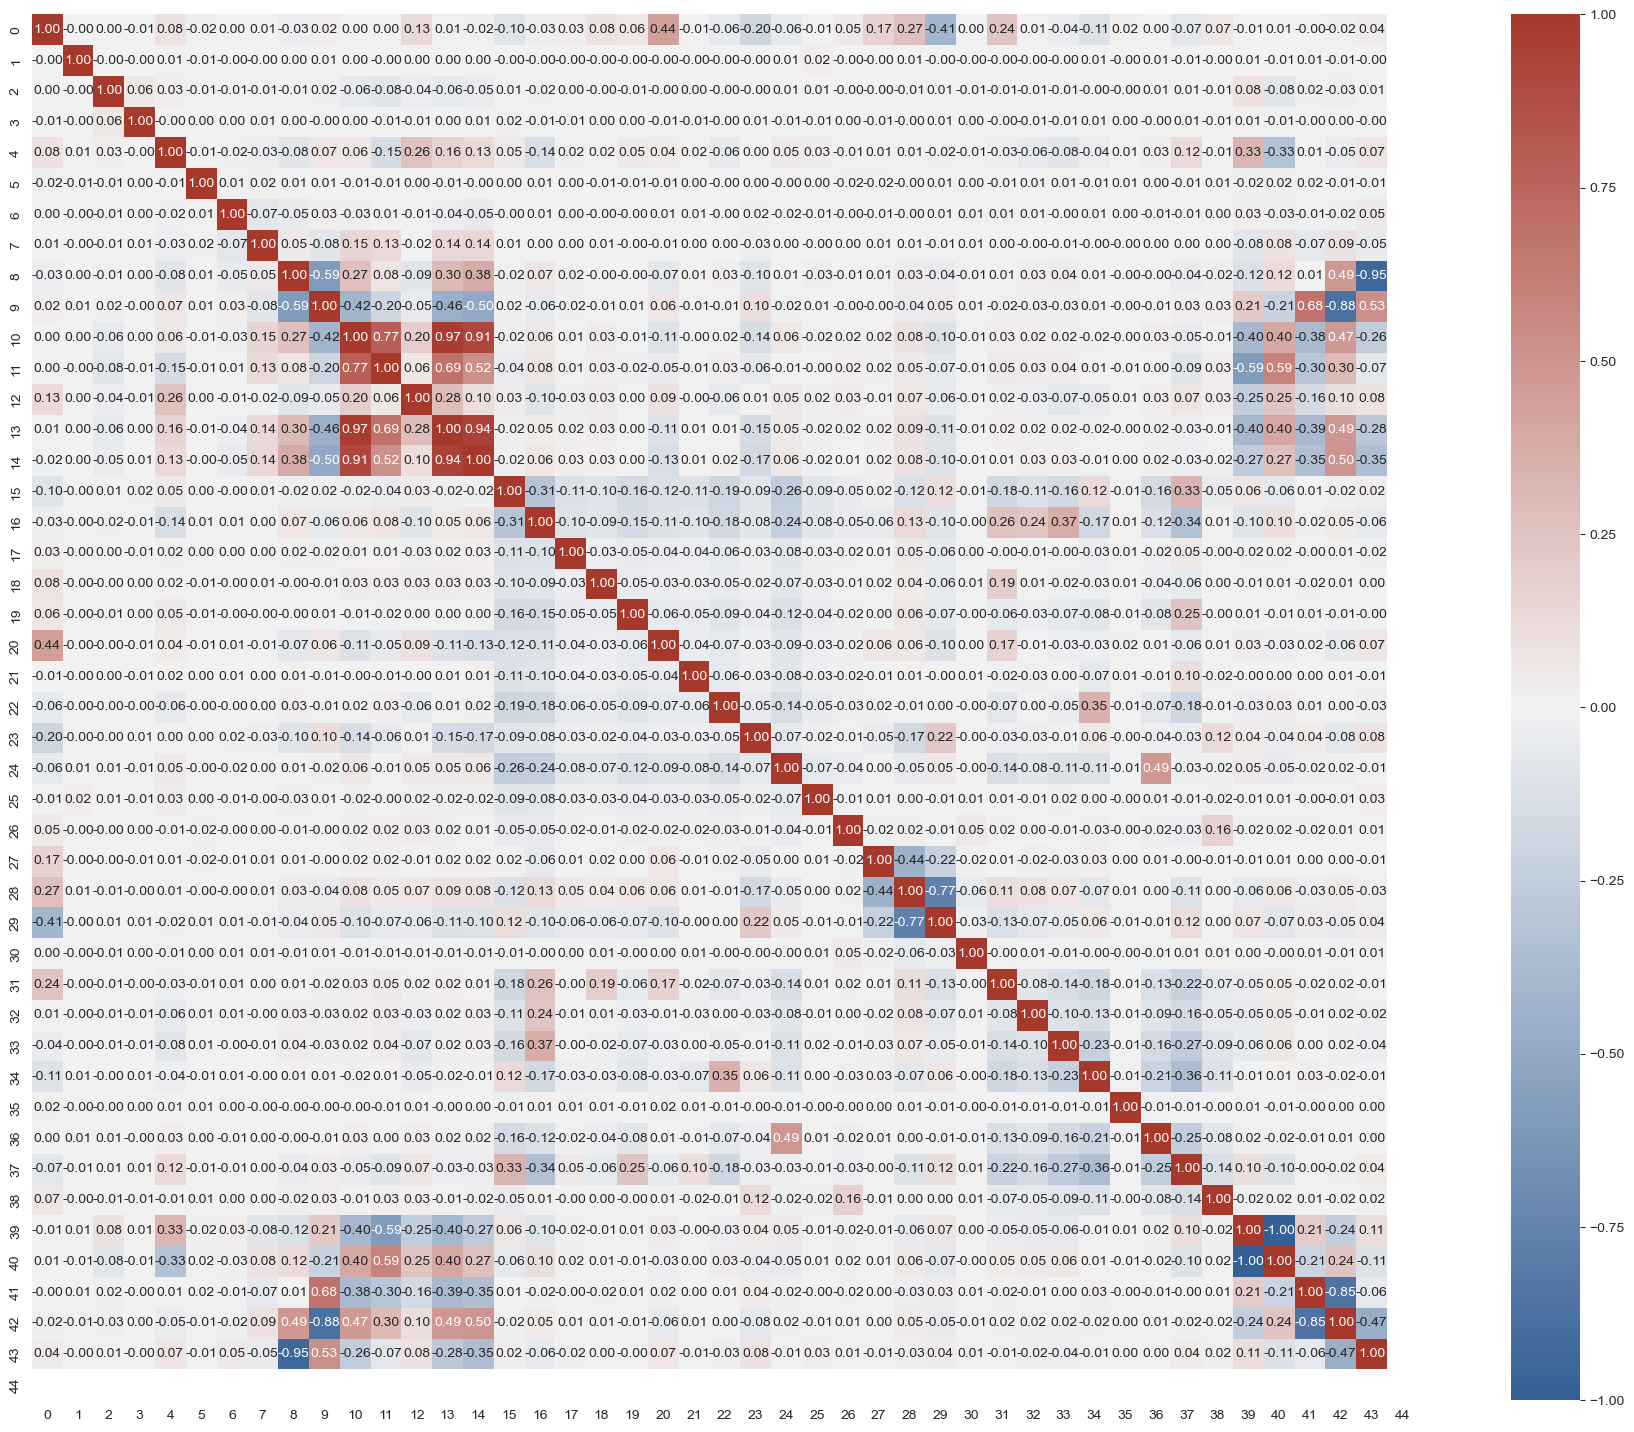

In [27]:
matrix = pd.DataFrame(X_train).corr()
plt.figure(figsize=(24,18))
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
_ = sns.heatmap(matrix, center=0, annot=True, 
                fmt='.2f', square=True, cmap=cmap)

Since we need to remove strong correlations including both negative and positive values, we build the matrix with absolute values of correlations. Next, we create a boolean mask to get the subset of the matrix. Note the mask method puts NaN values to the upper half and diagonal of the matrix. Last I chose a threshold of 0.95 to remove the correlated features. 

In [28]:
import numpy as np
# Convert to absolute values
matrix = pd.DataFrame(X_train).corr().abs()
# Create a boolean mask
mask = np.triu(np.ones_like(matrix, dtype=bool))
# Subset the matrix
reduced_matrix = matrix.mask(mask)
# Find cols that meet the threshold
to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > 0.95)] # [8,10,39]
print(bank_data.columns[8], bank_data.columns[10], bank_data.columns[39], bank_data.columns[43])
# removing the selected columns
X_train = X_train.drop(X_train.columns[to_drop], axis=1)
X_test = X_test.drop(X_test.columns[to_drop], axis=1)

pdays emp.var.rate education_unknown poutcome_nonexistent


### Apply SMOTE for minority over sampling <a class="anchor" id="smote"></a>

In [29]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = X_train.columns
data_X, data_y = os.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=data_X,columns=columns)
y_train = pd.DataFrame(data=data_y,columns=['target'])

### Apply PCA for dimensionality reduction <a class="anchor" id="pca"></a>

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)     

## 4. Developing Models <a class="anchor" id="developing-models"></a>


### Create a Logistic Regression model <a class="anchor" id="lr"></a>

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(X_train, y_train.values.ravel())
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred = y_pred, y_true = y_test)
res = pd.DataFrame()
res['lr_result'] = y_pred
lr_error = y_test - y_pred
res['lr_error'] = lr_error
output = pd.DataFrame(columns=['MSE','Training Score', 'Accuracy'],index=['Logistic Regression','Multilayer Perceptron','Random Forest'])
print(f'Accuracy of the Logistic Regression model is {accuracy*100:.2f}%')

Accuracy of the Logistic Regression model is 85.74%


In [32]:
from sklearn.metrics import accuracy_score, mean_squared_error
predict = lr.predict(X_test)
output['MSE']['Logistic Regression'] = mean_squared_error(y_test, predict)
output['Training Score']['Logistic Regression'] = lr.score(X_train, y_train)
output['Accuracy']['Logistic Regression'] = accuracy
print("Training set score: %f" % lr.score(X_train, y_train))
print("Test set score: %f" % lr.score(X_test, y_test))
print("MSE: %f" % mean_squared_error(y_test, predict))

Training set score: 0.867255
Test set score: 0.857351
MSE: 0.142649


### Create a Multilayer Perceptron model <a class="anchor" id="mlp"></a>

In [33]:
from sklearn.neural_network import MLPClassifier 
mlp = MLPClassifier(hidden_layer_sizes=(50,200,50), max_iter=300, activation='relu', solver='adam', random_state=1)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_pred = y_pred, y_true = y_test)
res['mlp_result'] = y_pred
mlp_error = y_test - y_pred
res['mlp_error'] = mlp_error
print(f'Accuracy of the multilayer Perceptron model is {accuracy*100:.2f}%') #

Accuracy of the multilayer Perceptron model is 88.70%


In [34]:
from sklearn.metrics import mean_squared_error
predict = mlp.predict(X_test)
output['MSE']['Multilayer Perceptron'] = mean_squared_error(y_test, predict)
output['Training Score']['Multilayer Perceptron'] = mlp.score(X_train, y_train)
output['Accuracy']['Multilayer Perceptron'] = accuracy
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))
print("MSE: %f" % mean_squared_error(y_test, predict))

Training set score: 0.992101
Test set score: 0.886973
MSE: 0.113027


### Create a Random Forest model <a class="anchor" id="rf"></a>

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_pred = y_pred, y_true = y_test)
res['rf_result'] = y_pred
rf_error = y_test - y_pred
res['rf_error'] = rf_error
print(f'Accuracy of the Random Forest model is {accuracy*100:.2f}%')

Accuracy of the Random Forest model is 88.71%


In [36]:
from sklearn.metrics import mean_squared_error
predict = rf.predict(X_test)
output['MSE']['Random Forest'] = mean_squared_error(y_test, predict)
output['Training Score']['Random Forest'] = rf.score(X_train, y_train)
output['Accuracy']['Random Forest'] = accuracy
print("Training set score: %f" % rf.score(X_train, y_train))
print("Test set score: %f" % rf.score(X_test, y_test))
print("MSE: %f" % mean_squared_error(y_test, predict))

Training set score: 1.000000
Test set score: 0.887095
MSE: 0.112905


### Compare results<a class="anchor" id="compare-results"></a>

In [37]:
print(output)

                            MSE Training Score  Accuracy
Logistic Regression    0.142649       0.867255  0.857351
Multilayer Perceptron  0.113027       0.992101  0.886973
Random Forest          0.112905            1.0  0.887095


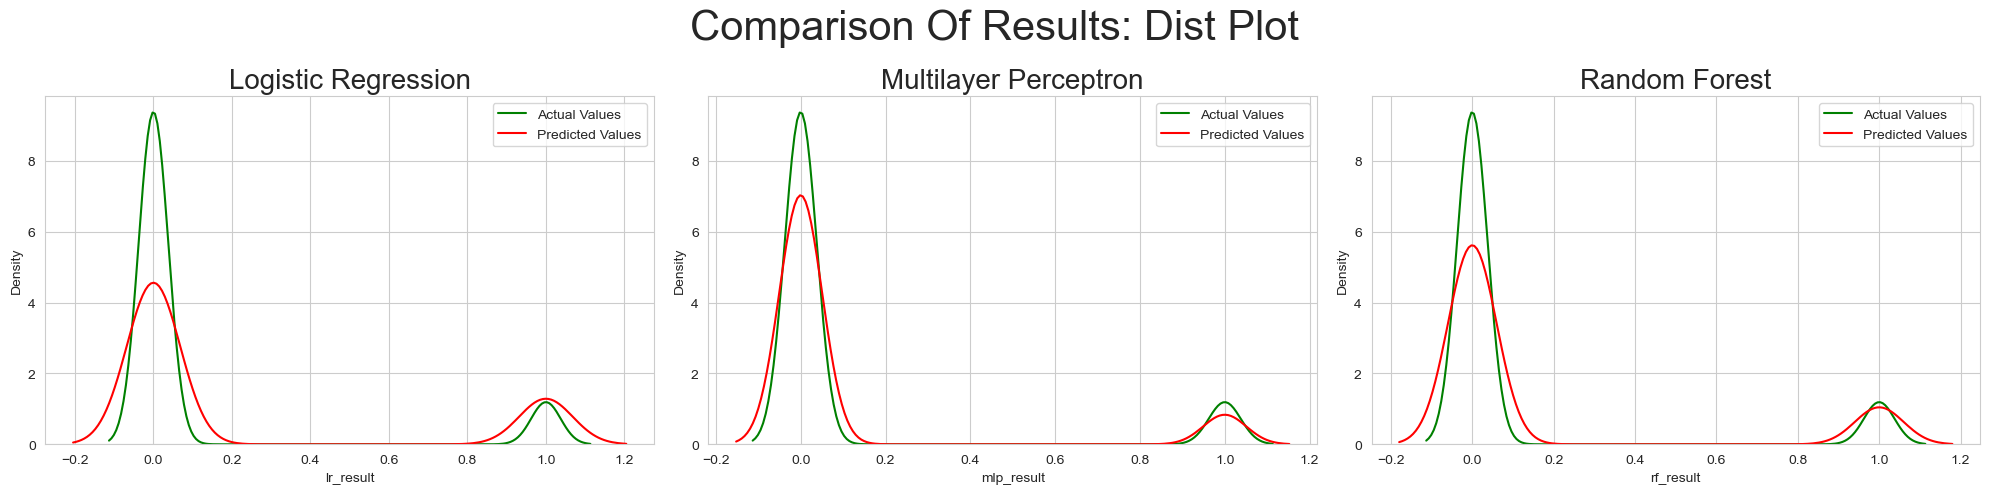

In [38]:
# result plots
fig, axes =plt.subplots(1,3, figsize=(20,5))
axes = axes.flatten()
res_cols = {
  "lr_result": "Logistic Regression",
  "mlp_result": "Multilayer Perceptron",
  "rf_result": "Random Forest",
}
for ax, col in zip(axes, res_cols):
    sns.distplot(bank_data['target'], hist=False, color="g", label="Actual Values",ax=ax)
    sns.distplot(res[col], hist=False, color="r", label="Predicted Values" , ax=ax)
    ax.set_title(res_cols[col],fontsize=20)
    ax.legend()
fig.suptitle("Comparison Of Results: Dist Plot",fontsize=30)
fig.tight_layout()

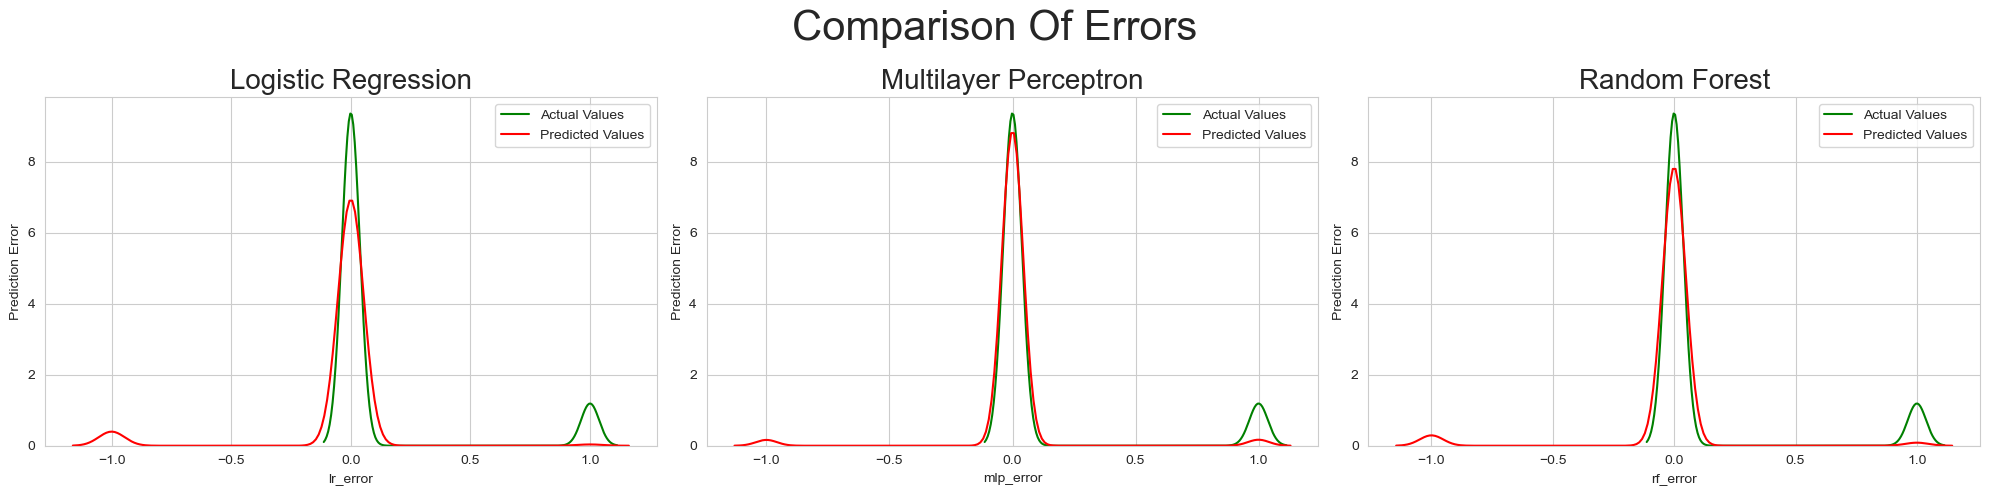

In [39]:
# error plots
fig, axes =plt.subplots(1,3, figsize=(20,5))
axes = axes.flatten()
err_cols = {
  "lr_error": "Logistic Regression",
  "mlp_error": "Multilayer Perceptron",
  "rf_error": "Random Forest",
}
for ax, col in zip(axes, err_cols):
    sns.distplot(bank_data['target'], hist=False, color="g", label="Actual Values",ax=ax)
    sns.distplot(res[col], hist=False, color="r", label="Predicted Values" , ax=ax)
    ax.set_title(err_cols[col],fontsize=20)
    ax.set_ylabel("Prediction Error")
    ax.legend()
fig.suptitle("Comparison Of Errors",fontsize=30)
fig.tight_layout()

## 5. Conclusion <a class="anchor" id="conclusion"></a>

In summary, Comparing above models, we conclude that Random Forest is the best model which is giving accuracy around 89%. Multilayer Perceptron gives a similar results and with Logistic Regression doing the poorest, which is around 85%.

We also have gained some insights by plotting the data. 
* In general, younger customers (<40 years old) are more likely to purchase the term deposit.
* Education level and profession affect customers' participation. For example, people are more willing to participate in the campaign if they either hold an admins, blue-collar, or technicians job or have a university degree or high school diploma.
* Repeated campaigns are more effective in some professions such as entrepreneurs
* Two attempted campaigns is enough for the majority of the population




## 6. Deployment <a class="anchor" id="deployment"></a>
We can deploy machine learning models as web services, i.e. deploy online models for predictions. Or sometimes we prefer deploying offline models in a batch processing way for its ability to run more complex models and handle a high volumn of job instances. We could also deploy models as embedded models directly to devices like a mobile phone. Here I briefly show deploying our model as a web service using Flask web framework.

### Persist the Random Forest model trained from above

In [40]:
import joblib
joblib.dump(rf, 'classifier.pkl')

['classifier.pkl']

### Serve the persisted model using Flask
For example, below takes input in a POST request through https://localhost:8080/predict and returns the prediction in a JSON response.

In [ ]:
from flask import Flask

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
     json_ = request.json
     query_df = pd.DataFrame(json_)
     query = pd.get_dummies(query_df)
    
     classifier = joblib.load('classifier.pkl')
     prediction = classifier.predict(query)
     return jsonify({'prediction': list(prediction)})


if __name__ == '__main__':
     app.run(port=8080)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8080
Press CTRL+C to quit
